<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/OSA_NAM_Final_With_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('OSA_Data_April_2023_1.csv').dropna()

# Check class distribution
class_counts = df['OSA'].value_counts()

In [2]:
df.head()

,Age,Sex,Height,Weight,BMI,Neck,MF,OSA
0,49,0,66.0,127,0,0,0,0
1,42,0,66.0,165,0,0,0,0
2,58,1,68.0,138,0,0,0,0
3,44,0,60.0,118,0,0,0,0
4,55,0,64.0,136,0,0,0,0


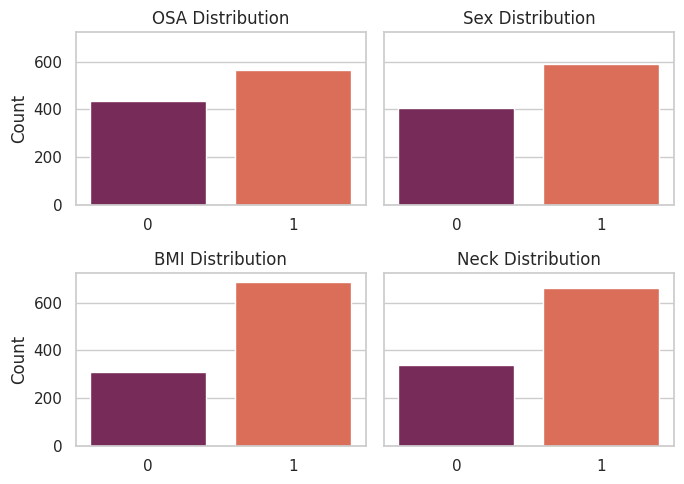

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['text.usetex'] = False

features = ['OSA', 'Sex', 'BMI', 'Neck']

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharey=True)

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.countplot(ax=axes[row, col], data=df, x=feature, hue=feature, palette='rocket', legend=False)
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Count' if col == 0 else '')

plt.tight_layout()
plt.savefig('osa_feature_distributions.png', dpi=100)
save_path = 'osa_feature_distributions.png'
plt.savefig(save_path, dpi=300)
plt.show()


In [4]:
# Feature ranking using correlation
corr = df.corr()
abs_corr = corr.abs().sort_values(by='OSA', ascending=False)
rank = abs_corr['OSA'].rank(ascending=False).astype(int)

# Balance the dataset using oversampling
from imblearn.over_sampling import RandomOverSampler
X = df.drop('OSA', axis=1)
y = df['OSA']
X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)
df_balanced = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['OSA'])], axis=1)

In [5]:
# Train/test split across multiple lines for clarity
X_train, X_test, y_train, y_test = train_test_split(
                  df_balanced.drop('OSA', axis=1),  # Features
                  df_balanced['OSA'],                       # Target
                  test_size=0.3,                                # % of test size
                  random_state=42                          # Reproducibility
)

In [6]:
# Feature selection
selector = SelectKBest(f_classif, k=7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [7]:
# Standardization
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_selected)
X_test_scaled = sc.transform(X_test_selected)

In [8]:
# Build a Keras NAM-like model with one hidden layer per feature
input_dim = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_dim,))

x = layers.Dense(32, activation="relu")(inputs)

x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# Predictions
y_train_pred_proba = model.predict(X_train_scaled).ravel()
y_test_pred_proba = model.predict(X_test_scaled).ravel()
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


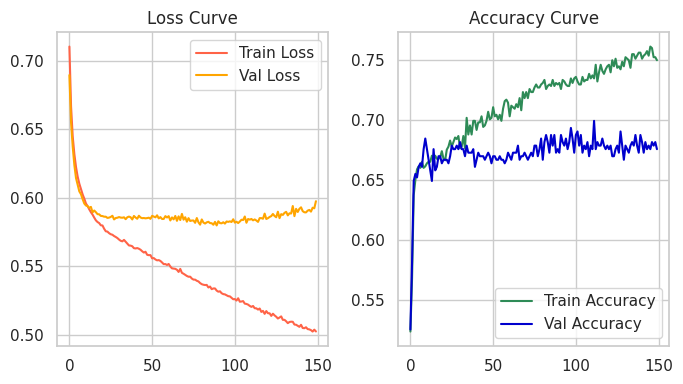

In [10]:
# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].plot(history.history['loss'], label='Train Loss', color='tomato')
axs[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
axs[0].set_title('Loss Curve')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='seagreen')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy', color='mediumblue')
axs[1].set_title('Accuracy Curve')
axs[1].legend()
plt.tight_layout()
save_path = 'training_history.png'
plt.savefig(save_path, dpi=300)
plt.show()

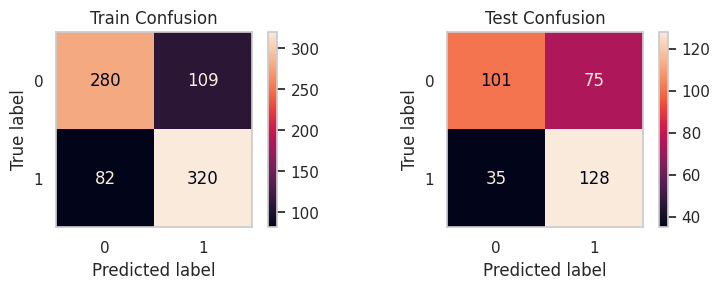

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='rocket')
ax[0].set_title('Train Confusion')
ax[0].grid(False)  # Remove grid

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='rocket')
ax[1].set_title('Test Confusion')
ax[1].grid(False)  # Remove grid

plt.tight_layout()
save_path = 'confusion_matrices.png'
plt.savefig(save_path, dpi=300)
plt.show()


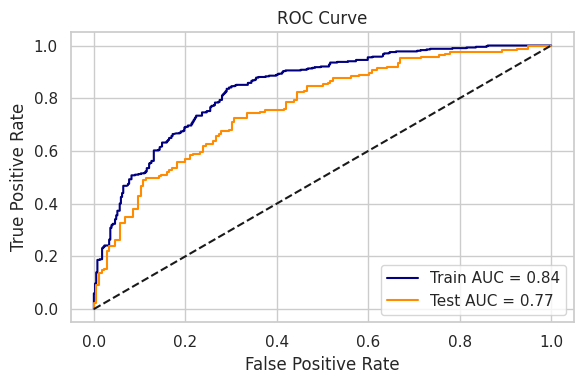

In [12]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.2f}", color="navy")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = 'roc_curve.png'
plt.savefig(save_path, dpi=300)
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for training data
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# # Print results
# print("Training Metrics:")
# print(f"Accuracy:  {train_acc:.4f}")
# print(f"Precision: {train_prec:.4f}")
# print(f"Recall:    {train_rec:.4f}")
# print(f"F1 Score:  {train_f1:.4f}\n")

# print("Testing Metrics:")
# print(f"Accuracy:  {test_acc:.4f}")
# print(f"Precision: {test_prec:.4f}")
# print(f"Recall:    {test_rec:.4f}")
# print(f"F1 Score:  {test_f1:.4f}")


In [14]:
import pandas as pd

# Prepare the data as a dictionary
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": [train_acc, train_prec, train_rec, train_f1],
    "Test": [test_acc, test_prec, test_rec, test_f1]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
metrics_df.T


,0,1,2,3
Metric,Accuracy,Precision,Recall,F1 Score
Train,0.758534,0.745921,0.79602,0.770156
Test,0.675516,0.630542,0.785276,0.699454


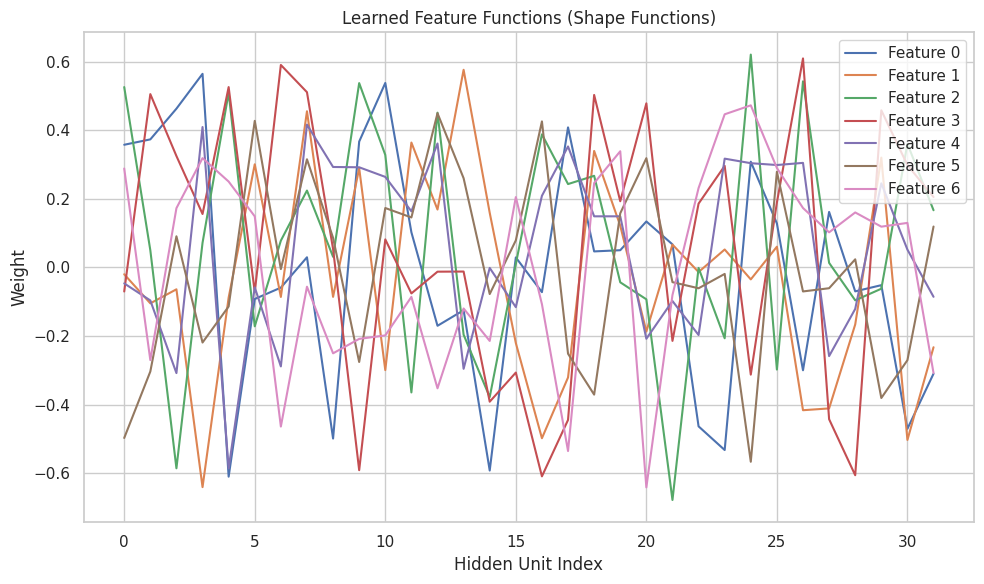

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract weights of the first dense layer assuming one neuron per feature
first_layer_weights = model.layers[1].get_weights()[0]
n_features = X_test.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.plot(first_layer_weights[i], label=f'Feature {i}')
plt.title('Learned Feature Functions (Shape Functions)')
plt.xlabel('Hidden Unit Index')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = 'feature_functions.png'
plt.savefig(save_path, dpi=300)
plt.show()


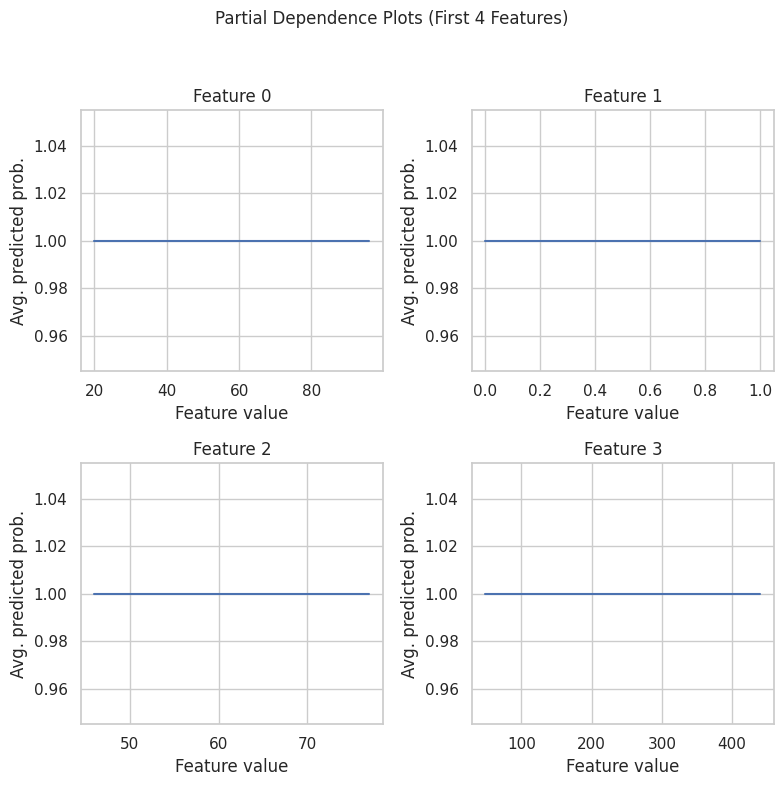

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pdp(model, X, feature_index, grid_resolution=20):
    X_np = X.to_numpy() if hasattr(X, 'to_numpy') else X.copy()
    grid = np.linspace(X_np[:, feature_index].min(), X_np[:, feature_index].max(), grid_resolution)
    pdp = []
    for val in grid:
        X_temp = X_np.copy()
        X_temp[:, feature_index] = val
        preds = model.predict(X_temp, verbose=0).flatten()
        pdp.append(np.mean(preds))
    return grid, pdp

# Plot PDPs for the first 4 features
num_features = min(4, X_test.shape[1])
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs = axs.flatten()

for i in range(num_features):
    grid, pdp = compute_pdp(model, X_test, i)
    axs[i].plot(grid, pdp)
    axs[i].set_title(f'Feature {i}')
    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Avg. predicted prob.')
    axs[i].grid(True)

plt.suptitle("Partial Dependence Plots (First 4 Features)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_path = 'pdp_plots.png'
plt.savefig(save_path, dpi=300)
plt.show()


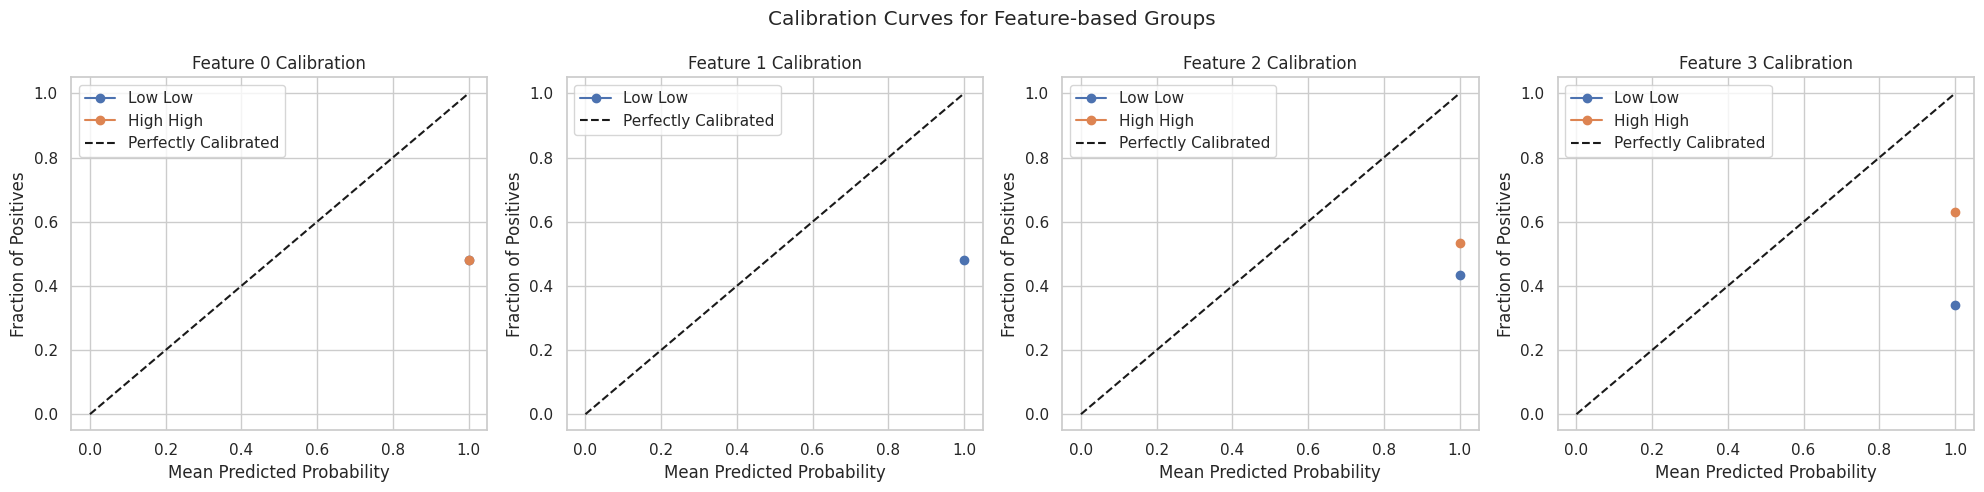

In [17]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities
y_probs = model.predict(X_test, verbose=0).flatten()

# Convert to NumPy if needed
X_np = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
y_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Number of features to show
num_features = min(4, X_np.shape[1])  # change as needed
n_bins = 10

fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

for i in range(num_features):
    # Bin the feature into 2 groups (e.g., low/high)
    feature_vals = X_np[:, i]
    median = np.median(feature_vals)
    mask_low = feature_vals <= median
    mask_high = feature_vals > median

    for label, mask in zip(['Low', 'High'], [mask_low, mask_high]):
        if np.sum(mask) < 2:  # Avoid crashing on very small groups
            continue
        prob_true, prob_pred = calibration_curve(y_np[mask], y_probs[mask], n_bins=n_bins)
        axs[i].plot(prob_pred, prob_true, marker='o', label=f'{label} {label}')

    axs[i].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    axs[i].set_title(f'Feature {i} Calibration')
    axs[i].set_xlabel('Mean Predicted Probability')
    axs[i].set_ylabel('Fraction of Positives')
    axs[i].legend()
    axs[i].grid(True)

plt.suptitle('Calibration Curves for Feature-based Groups')
plt.tight_layout()
save_path = 'calibration_curves.png'
plt.savefig(save_path, dpi=300)
plt.show()


### 🔧 Enhanced Neural Additive Model (NAM)

In [18]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Add, Activation, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define NAM model: one subnetwork per input feature
input_dim = X_train_scaled.shape[1]
inputs = []
feature_outputs = []

for i in range(input_dim):
    inp = Input(shape=(1,))
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dense(1)(x)  # Linear output per feature
    inputs.append(inp)
    feature_outputs.append(x)

# Sum all feature contributions
summed = Add()(feature_outputs)
output = Activation('sigmoid')(summed)

# Build model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │         64 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │         64 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │         64 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │         64 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │         64 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 5,159 (20.15 KB)

 Trainable params: 4,711 (18.40 KB)

 Non-trainable params: 448 (1.75 KB)

### 📦 Convert Feature Matrix to List Format for NAM

In [19]:
# Convert training and test sets into list of single-feature arrays
X_train_list = [X_train_scaled[:, i].reshape(-1, 1) for i in range(X_train_scaled.shape[1])]
X_test_list = [X_test_scaled[:, i].reshape(-1, 1) for i in range(X_test_scaled.shape[1])]


### 🏋️‍♂️ Train the NAM Model

In [20]:
history = model.fit(
    X_train_list, y_train,
    validation_data=(X_test_list, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.4954 - loss: 1.2494 - val_accuracy: 0.6224 - val_loss: 0.8240
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6307 - loss: 0.9075 - val_accuracy: 0.6283 - val_loss: 0.8272
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6216 - loss: 0.8704 - val_accuracy: 0.5870 - val_loss: 0.8286
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5913 - loss: 0.8935 - val_accuracy: 0.6372 - val_loss: 0.8145
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6594 - loss: 0.8273 - val_accuracy: 0.5811 - val_loss: 0.8165
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6200 - loss: 0.8279 - val_accuracy: 0.6165 - val_loss: 0.8058
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6064 - loss: 0.8579 - val_accuracy: 0.6401 - val_loss: 0.7985
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6052 - loss: 0.8381 - val_accuracy: 0

### 📈 Accuracy and Loss Curves

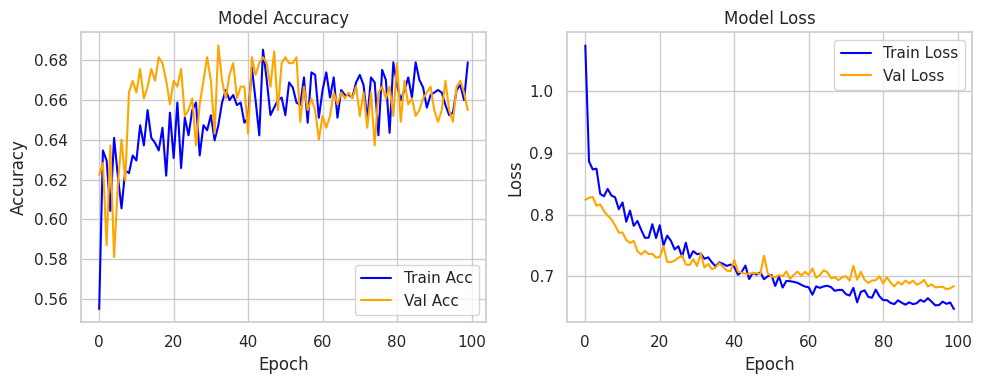

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 📊 Evaluation: Confusion Matrix and Classification Report

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


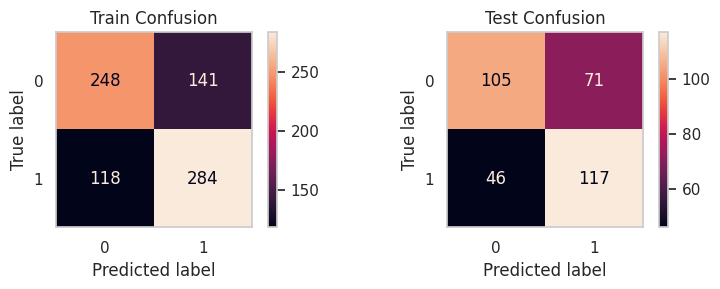

,0,1,2,3
Metric,Accuracy,Precision,Recall,F1 Score
Train,0.672566,0.668235,0.706468,0.68682
Test,0.654867,0.62234,0.717791,0.666667


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# === Generate Predictions ===
y_train_pred_proba = model.predict(X_train_list)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

y_test_pred_proba = model.predict(X_test_list)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# === Plot Confusion Matrices ===
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='rocket')
ax[0].set_title('Train Confusion')
ax[0].grid(False)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='rocket')
ax[1].set_title('Test Confusion')
ax[1].grid(False)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()

# === Compute Metrics ===
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# === Create Summary Table ===
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": [train_acc, train_prec, train_rec, train_f1],
    "Test": [test_acc, test_prec, test_rec, test_f1]
}

metrics_df = pd.DataFrame(metrics_data)

# Transpose for display
metrics_df.T


### 🔍 Optional: Partial Dependence Plot (PDP)-like Interpretability

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


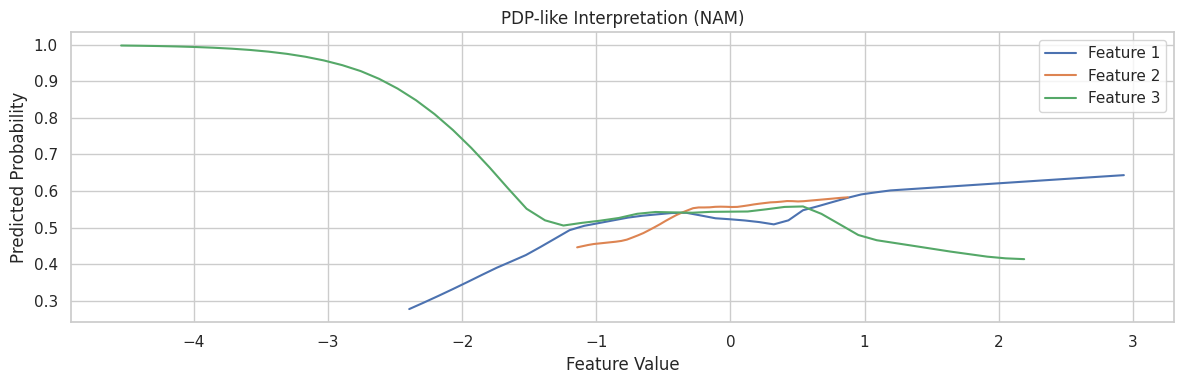

In [23]:
import numpy as np

def compute_nam_pdp(model, X, feature_index, grid_resolution=50):
    grid = np.linspace(X[:, feature_index].min(), X[:, feature_index].max(), grid_resolution)
    pdp_vals = []

    for val in grid:
        X_temp = [X[:, i].reshape(-1, 1) for i in range(X.shape[1])]
        X_temp[feature_index] = np.full_like(X_temp[feature_index], val)
        preds = model.predict(X_temp)
        pdp_vals.append(np.mean(preds))

    return grid, pdp_vals

# Example PDP plot for first 3 features
plt.figure(figsize=(12, 4))
for i in range(3):
    grid, pdp_vals = compute_nam_pdp(model, X_test_scaled, i)
    plt.plot(grid, pdp_vals, label=f'Feature {i+1}')
plt.title('PDP-like Interpretation (NAM)')
plt.xlabel('Feature Value')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
